# Homework 5
### Astrostatistics, University of Washington


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall the MCMC lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then visually compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models. **There's no need to do quantitative model-comparison**.
- Use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can solve this problem by generalizing the code from class.

In [ ]:
hw_done = True   ## change this to True to mark your homework as done.

The data:

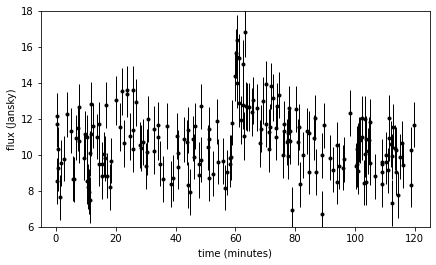

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import pandas as pd
from astroML.plotting.mcmc import plot_mcmc
import pymc3 as pm

def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

# read data
data = np.loadtxt('data/burst.dataset.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## One Burst

In [2]:
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

np.random.seed(10)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

alpha = np.linspace(-9.99,9.99,200)
dalpha = alpha[1]-alpha[0]
prior_alpha=[]
for i in range(0,len(alpha)):
    prior_alpha.append(alpha[i]**(-1))


with pm.Model():
    b0 = pm.Uniform('b0', 5, 15)
    A = pm.Uniform('A', 1, 10)
    T = pm.Uniform('T', 57, 61)
    log_alpha =  pm.Uniform('log_alpha', -10, 10)

    y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T), sd=sigma_y, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=100000, tune=1000, step=step, chains=10)

/tmp/ipykernel_60/2578585101.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=100000, tune=1000, step=step, chains=10)
Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


Sampling 10 chains for 1_000 tune and 100_000 draw iterations (10_000 + 1_000_000 draws total) took 374 seconds.
The number of effective samples is smaller than 10% for some parameters.


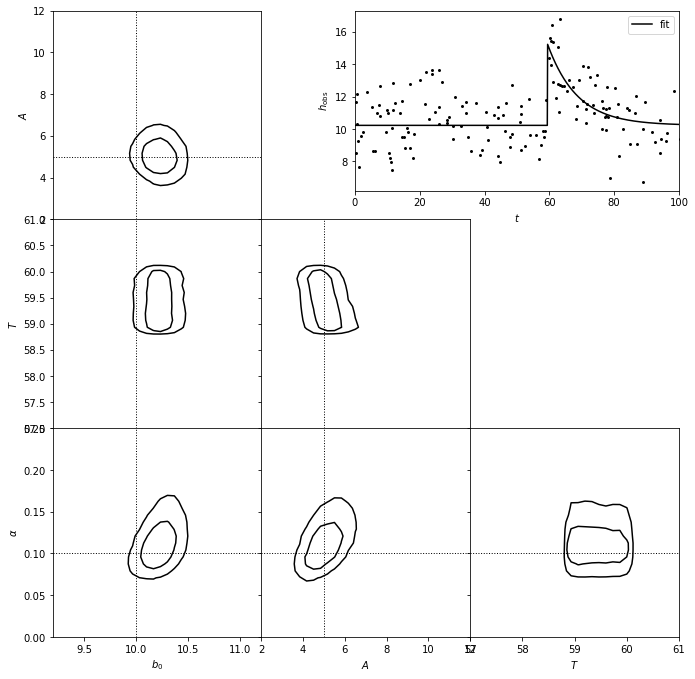

In [3]:
df = traces_to_pandas(traces, 1000)
df["alpha"] = np.exp(traces['log_alpha'])
del df["log_alpha"]

variables = ['b0', 'A', 'T', 'alpha']
labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (57, 61), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = burst(t_fit, **df.median())
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k', label="fit")
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

## Two bursts

In [2]:
def burst(t, b0, A, alpha, T, A1, alpha1, T1):
    """Burst model"""
    mask = (t >= T)
    mask_ = (t >= T1)
    y = b0 + mask * A * np.exp(-alpha * (t - T))+ mask_ * A1 * np.exp(-alpha1 * (t - T1))
    return y

np.random.seed(10)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 17
A1_true = 5
alpha1_true = 0.1
T1_true = 59

sigma = 1.0


with pm.Model():
    b0 = pm.Uniform('b0', 9.5, 11)
    A = pm.Uniform('A', 1, 10)
    T = pm.Uniform('T', 17, 23)
    log_alpha =  pm.Uniform('log_alpha', -10, 10)
    A1 = pm.Uniform('A1', 0, 8)
    T1 = pm.Uniform('T1', 57, 61)
    log_alpha1 =  pm.Uniform('log_alpha1', -10, 10)

    y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T,  A1, np.exp(log_alpha1), T1), sd=sigma_y, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=100000, tune=1000, step=step, chains=16) 

/tmp/ipykernel_446/3587821505.py:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=100000, tune=1000, step=step, chains=16)
Multiprocess sampling (16 chains in 4 jobs)
CompoundStep
>Metropolis: [log_alpha1]
>Metropolis: [T1]
>Metropolis: [A1]
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


Sampling 16 chains for 1_000 tune and 100_000 draw iterations (16_000 + 1_600_000 draws total) took 967 seconds.
The number of effective samples is smaller than 10% for some parameters.


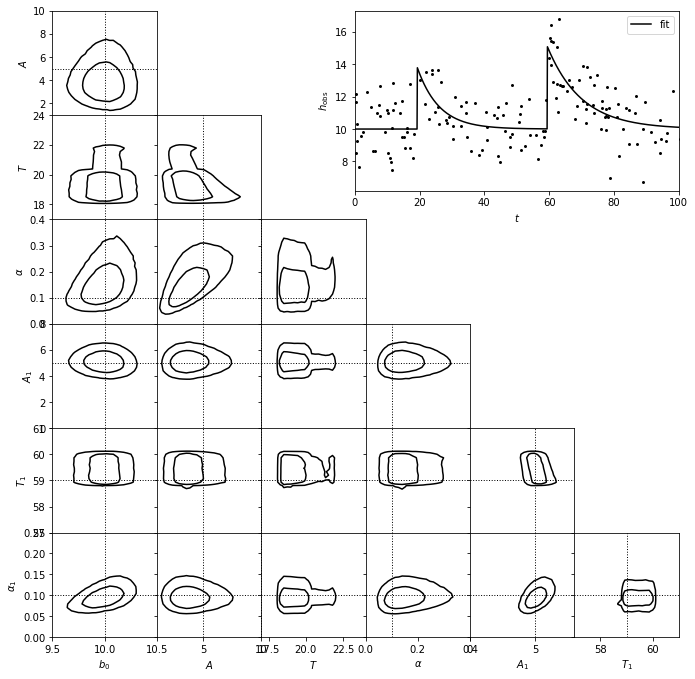

In [3]:
df = traces_to_pandas(traces, 1000)
df["alpha"] = np.exp(traces['log_alpha'])
del df["log_alpha"]
df["alpha1"] = np.exp(traces['log_alpha1'])
del df["log_alpha1"]

variables = ['b0', 'A', 'T', 'alpha',  'A1', 'T1', 'alpha1']
labels = ['$b_0$', '$A$', '$T$', r'$\alpha$', '$A_1$', '$T_1$', r'$\alpha_1$']
limits = [(9.5, 10.5), (1, 10), (17, 24), (0.0, 0.4), ( 0, 8), (57, 61), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true, A1_true, T1_true, alpha1_true]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = burst(t_fit, **df.median())
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true, A1_true, alpha1_true, T1_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k', label="fit")
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()